# Modelo 3DOF de Foguete
Modelagem de foguete de foguetemodelismo em 3 graus de liberdade, sob o objetivo de controlar a altitude do foguete por meio de freio aerodinâmico.
Entradas de Controle - Cd (Coeficente de Arrasto) e T (Empuxo do Motor)
Entrada de Perturbação - w (Vento Horizontal)


###Instalação dos Pacotes Necessários

In [50]:
%pip install numpy
%pip install scipy
%pip install sympy
%pip install tbcontrol
%pip install seaborn
%pip install control


import numpy as np
from scipy.integrate import solve_ivp
import sympy as sp
import sympy.physics.mechanics as mech
mech.init_vprinting()
from sympy.abc import s
from sympy.physics.control.lti import TransferFunction
from sympy.physics.control.control_plots import bode_plot
import control as ct
from tbcontrol.symbolic import routh
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from seaborn import color_palette
colors = color_palette()

In [51]:
from sympy.physics.control.control_plots import pole_zero_plot

In [52]:
from sympy.integrals.transforms import inverse_laplace_transform as invLaplace

In [53]:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

### Modelagem matemática - equação de movimento do mecanismo

Equacionamento físico do sistema utilizando o Teorema da Resultante e o TQMA, baseando-se no método de Newton-Euler

Definição de variáveis e funções simbólicas (pacote `sympy`):

In [54]:
from re import T
m, g, Jg, ρ, A_m, A_f, Cl, D_Cp, AA, vx, vy, K_c, ε, α, φ= sp.symbols(
    'm, g, Jg, ρ, A_m, A_f, Cl, D_Cp, AA, vx, vy, K_c, ε, α, φ', positive=True)
t = sp.symbols('t')
w = sp.symbols('w')
θ = sp.Function('θ')(t)
x = sp.Function('x')(t)
y = sp.Function('y')(t)
Cd = sp.Function('Cd')(t)
T = sp.Function('T')(t)
s = sp.symbols('s')

Cinemática - Velocidade Relativa ao Vento

In [55]:
vx_vento = x.diff(t) - w
vy_vento = y.diff(t)
print(vx_vento)
print(vy_vento)

-w + Derivative(x(t), t)
Derivative(y(t), t)


Ângulo de Velocidade Relativa e de Ataque

In [56]:
φ = sp.pi/2 - sp.atan(vx_vento/vy_vento)
α = φ - θ

Força de Arrasto

In [57]:
D = Cd * sp.Rational(1, 2)* ρ * A_f * (vx_vento**2 + vy_vento**2)
D

      ⎛        2    2⎞   
A_f⋅ρ⋅⎝(-w + ẋ)  + ẏ ⎠⋅Cd
─────────────────────────
            2            

Força de Sustentação

In [58]:
L = Cl * sp.Rational(1, 2)* ρ * A_m * (vx_vento**2 + vy_vento**2) * (α)
L

        ⎛        2    2⎞ ⎛         ⎛-w + ẋ⎞   π⎞
Aₘ⋅Cl⋅ρ⋅⎝(-w + ẋ)  + ẏ ⎠⋅⎜-θ - atan⎜──────⎟ + ─⎟
                         ⎝         ⎝  ẏ   ⎠   2⎠
────────────────────────────────────────────────
                       2                        

Equações Diferenciais Governantes

In [59]:
from operator import eq
eqx = m*x.diff(t, 2) - L*sp.cos(φ+sp.pi/2) + D*sp.cos(φ) - T*sp.cos(θ)
eqy = m*y.diff(t, 2) - L*sp.sin(φ+sp.pi/2) + D*sp.sin(φ) + m*g - T*sp.sin(θ)
eqθ = Jg*θ.diff(t, 2) - L*D_Cp*sp.sin(α+sp.pi/2) + D*D_Cp*sp.sin(α)

In [60]:
d2x_s = sp.solve(eqx, x.diff(t, 2))[0]
d2x_s.simplify()

              ______________________                    ______________________ ↪
             ╱  2            2    2                    ╱  2            2    2  ↪
            ╱  w  - 2⋅w⋅ẋ + ẋ  + ẏ                    ╱  w  - 2⋅w⋅ẋ + ẋ  + ẏ   ↪
A_f⋅w⋅ρ⋅   ╱   ──────────────────── ⋅Cd⋅ẏ   A_f⋅ρ⋅   ╱   ────────────────────  ↪
          ╱              2                          ╱              2           ↪
        ╲╱              ẏ                         ╲╱              ẏ            ↪
───────────────────────────────────────── - ────────────────────────────────── ↪
                    2                                           2              ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                               ↪

↪                         ______________________                      ________ ↪
↪                        ╱  2            2    2                      ╱  2      ↪
↪                 

In [61]:
d2y_s = sp.solve(eqy, y.diff(t, 2))[0]
d2y_s.simplify()

              ______________________                         _________________ ↪
             ╱  2            2    2                         ╱  2            2  ↪
            ╱  w  - 2⋅w⋅ẋ + ẋ  + ẏ       2                 ╱  w  - 2⋅w⋅ẋ + ẋ   ↪
  A_f⋅ρ⋅   ╱   ──────────────────── ⋅Cd⋅ẏ    Aₘ⋅Cl⋅w⋅ρ⋅   ╱   ──────────────── ↪
          ╱              2                               ╱              2      ↪
        ╲╱              ẏ                              ╲╱              ẏ       ↪
- ──────────────────────────────────────── + ───────────────────────────────── ↪
                     2                                           2             ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                               ↪

↪ _____                       ______________________                           ↪
↪    2                       ╱  2            2    2                            ↪
↪ + ẏ             

In [62]:
d2θ_s = sp.solve(eqθ, θ.diff(t, 2))[0]
d2θ_s.simplify()

        ⎛             2       ⎛        ⎛w - ẋ⎞⎞               ⎛        ⎛w - ẋ⎞ ↪
-D_Cp⋅ρ⋅⎜2⋅A_f⋅(w - ẋ) ⋅Cd⋅cos⎜θ - atan⎜─────⎟⎟ + 2⋅A_f⋅Cd⋅cos⎜θ - atan⎜─────⎟ ↪
        ⎝                     ⎝        ⎝  ẏ  ⎠⎠               ⎝        ⎝  ẏ  ⎠ ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                               ↪

↪ ⎞  2                  2      ⎛        ⎛w - ẋ⎞⎞                  2    ⎛       ↪
↪ ⎟⋅ẏ  + 2⋅Aₘ⋅Cl⋅(w - ẋ) ⋅θ⋅sin⎜θ - atan⎜─────⎟⎟ - 2⋅Aₘ⋅Cl⋅(w - ẋ) ⋅sin⎜θ - at ↪
↪ ⎠                            ⎝        ⎝  ẏ  ⎠⎠                       ⎝       ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                                                                              ↪

↪   ⎛w - ẋ⎞⎞     ⎛w - ẋ⎞                  2    ⎛        ⎛w - ẋ⎞⎞               ↪
↪ an⎜─────⎟⎟⋅atan⎜─────⎟ - π⋅Aₘ⋅Cl⋅(w - ẋ) ⋅sin⎜θ - atan⎜─────⎟⎟ + 2⋅Aₘ⋅Cl⋅θ⋅s ↪
↪   ⎝  ẏ  ⎠

###Linearização do Modelo

Imposição da Condição de Equilíbrio (Voo Vertical com Aceleração Nula) e dados dinâmicos do foguete Odisseia II

In [63]:
eqxs = eqx.subs({ φ: θ, θ.diff(t): 0, x.diff(t): 6, y.diff(t): vy, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
eqys = eqy.subs({ φ: θ,θ.diff(t): 0, x.diff(t): 6, y.diff(t): vy, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
eqθs = eqθ.subs({ φ: θ,θ.diff(t): 0, x.diff(t): 6, y.diff(t): vy, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
eqys

              2                      d              
0.004501875⋅vy  - 558.26⋅sin(θ) + 27⋅──(vy) + 264.87
                                     dt             

Cálculo da Velocidade Vertical Necessária para que haja Voo Vertical com Aceleração Nula

In [64]:
abs(sp.solve(eqys.subs({θ: np.pi/2 }), vy)[0])

                  │    ___________________________│
                  │   ╱                    d      │
0.272108843537415⋅│  ╱  880170.0 - 81000.0⋅──(vy) │
                  │╲╱                      dt     │

In [65]:
0.2721*((880170-81000)**(1/2))

243.2473558329052

Equações de movimento linearizadas, em termos das variáveis de estado incrementais $\mathbf{x} = (y, \theta,\dot x, \dot y, \dot \theta)$, expressa na forma de espaço de estados com as entradas $Cd, w, T$ representando variações incrementais ao redor da condição de equilíbrio:
$\dfrac{\text{d} \mathbf{x}}{\text{d} t} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u} + \mathbf{E} \mathbf{w}$

In [66]:
A3 = [ d2x_s.diff(i).subs({ φ: θ, θ.diff(t): 0, θ: (sp.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5}) for i in [ y, θ, x.diff(t), y.diff(t), θ.diff(t)] ]
A4 = [ d2y_s.diff(i).subs({ φ: θ, θ.diff(t): 0, θ: (sp.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5}) for i in [ y, θ, x.diff(t), y.diff(t), θ.diff(t)] ]
A5 = [ d2θ_s.diff(i).subs({ φ: θ, θ.diff(t): 0, θ: (sp.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5}) for i in [ y, θ, x.diff(t), y.diff(t), θ.diff(t)] ]

In [67]:
B3 = d2x_s.diff(Cd).subs({ φ: θ, θ.diff(t): 0, θ: (np.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
B4 = d2y_s.diff(Cd).subs({ φ: θ, θ.diff(t): 0, θ: (np.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
B5 = d2θ_s.diff(Cd).subs({ φ: θ, θ.diff(t): 0, θ: (np.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})

In [68]:
E3 = d2x_s.diff(w).subs({ φ: θ, θ.diff(t): 0, θ: (np.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
E4 = d2y_s.diff(w).subs({ φ: θ, θ.diff(t): 0, θ: (np.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})
E5 = d2θ_s.diff(w).subs({ φ: θ, θ.diff(t): 0, θ: (np.pi/2), x.diff(t): 6, y.diff(t): 243.24, α: 0,Cd: 0.35, w: 6, m: 27, T:558.26 ,Jg:12.622, A_f:0.021 ,A_m:0.021,g:9.81 ,ρ:1.225 ,D_Cp:0.381 ,Cl:1.5})

In [69]:
A = sp.Matrix([ [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], A3, A4, A5])
A

⎡0          0                  0                    1            0⎤
⎢                                                                 ⎥
⎢0          0                  0                    0            1⎥
⎢                                                                 ⎥
⎢0  21.6025251137037   0.133258358333333   1.32814766129474e-19  0⎥
⎢                                                                 ⎥
⎢0          0                  0           -0.0811137833333333   0⎥
⎢                                                                 ⎥
⎣0  -26.4173966736054  -0.108606301075503           0            0⎦

In [70]:
B = sp.Matrix([ [0], [0], [B3], [B4], [B5]])
B

⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢    -28.18588094     ⎥
⎢                     ⎥
⎣-1.40660783817986e-15⎦

In [71]:
E = sp.Matrix([[0], [0], [C3], [C4], [C5]])
E

⎡                    0                     ⎤
⎢                                          ⎥
⎢                    0                     ⎥
⎢                                          ⎥
⎢            -0.133258358333333            ⎥
⎢                                          ⎥
⎢    0.273028356240937 - 0.086907625⋅π     ⎥
⎢                                          ⎥
⎣0.108606301075503 - 4.33709866237006e-18⋅π⎦

###Funções de Transferência do Sistema
Desenvolvimento dos Equacionamentos Necessários para definir as funções de transferência para as entradas $Cd, w$, para o vetor de observações $o(t) = y(t)$ obtendo:

$G1 = Y(s)/Cd(s)$

$G2 = Y(s)/W(s)$

In [72]:
O = sp.Matrix([[1],[0],[0],[0],[0]])

In [73]:
G1 = O.transpose()*(((s * sp.eye(5)) - A).inv())*B
G2 = O.transpose()*(((s * sp.eye(5)) - A).inv())*C
numG1, denG1 = sp.fraction(G1[0])
numG2, denG2 = sp.fraction(G2[0])

In [74]:
def poly_to_coeffs(poly_expr, symbol):
    poly = sp.poly(poly_expr, symbol)
    coeffs = poly.all_coeffs()
    return [float(c) for c in coeffs]

In [75]:
T1 = ct.tf(poly_to_coeffs(numG1, s), poly_to_coeffs(denG1, s))
T2 = ct.tf(poly_to_coeffs(numG2, s), poly_to_coeffs(denG2, s))

In [76]:
Ts1 = TransferFunction(numG1,denG1,s)
Ts1

                     3                     2                                   ↪
      - 28.18588094⋅s  + 3.75600422224319⋅s  - 744.597597386993⋅s + 33.0949753 ↪
────────────────────────────────────────────────────────────────────────────── ↪
     5                4                     3                      2           ↪
1.0⋅s  - 0.052144575⋅s  + 26.4065875840002⋅s  + 0.968646424338457⋅s  - 0.09524 ↪

↪              
↪ 956087       
↪ ─────────────
↪              
↪ 12546329801⋅s

In [77]:
Ts2 = TransferFunction(numG2,denG2,s)
Ts2

                                    ⎛     3                      2             ↪
(0.273028356240937 - 0.086907625⋅π)⋅⎝1.0⋅s  - 0.133258358333333⋅s  + 26.417396 ↪
────────────────────────────────────────────────────────────────────────────── ↪
             5                4                     3                      2   ↪
        1.0⋅s  - 0.052144575⋅s  + 26.4065875840002⋅s  + 0.968646424338457⋅s  - ↪

↪                             ⎞
↪ 6736054⋅s - 1.17416856567509⎠
↪ ─────────────────────────────
↪                              
↪  0.0952412546329801⋅s        

### Análise de estabilidade do modelo linearizado

Análise Baseada na Verificação da Posição dos Polos do Sistema

Polinômio característico da matriz ${A}$:

In [78]:
p = A.charpoly('s')
p

PurePoly(1.0*s**5 - 0.052144575*s**4 + 26.4065875840002*s**3 + 0.9686464243384 ↪

↪ 58*s**2 - 0.09524125463298*s, s, domain='RR')

Tabela de Routh do polinômio caracterísitico:

In [79]:
RH_t =routh(p)
RH_t

⎡       1.0         26.4065875840002   -0.09524125463298⎤
⎢                                                       ⎥
⎢  -0.052144575     0.968646424338458          0        ⎥
⎢                                                       ⎥
⎢44.9827563290414   -0.09524125463298          0        ⎥
⎢                                                       ⎥
⎢0.968536019482229          0                  0        ⎥
⎢                                                       ⎥
⎢-0.09524125463298          0                  0        ⎥
⎢                                                       ⎥
⎣        0                  0                  0        ⎦

In [80]:
sp.solve(p, s)

[-0.0811137833333333, 0.0, 0.0444534360557846, 0.0444024611387743 - 5.13920980 ↪

↪ 415436⋅ⅈ, 0.0444024611387743 + 5.13920980415436⋅ⅈ]

Plots de Zeros e Polos para as Funções de Transferência

Mapa de Polos e Zeros para G4 (Relativo a Cd)

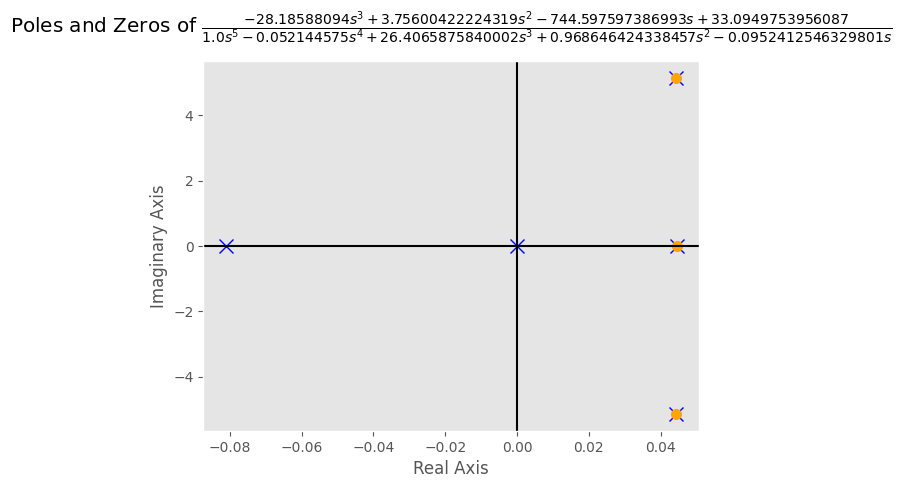

In [81]:
pole_zero_plot(TransferFunction(numG1,denG1,s))

Mapa de Polos e Zeros para G2 (Relativo a w)

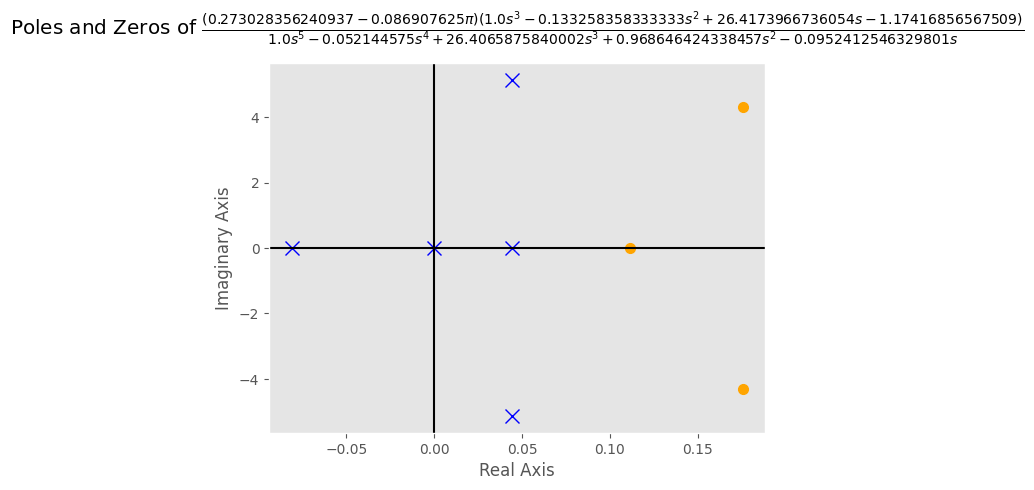

In [82]:
pole_zero_plot(TransferFunction(numG2,denG2,s))

###Análise no Domínio da Frequência
Desenvolvimento e análise dos Diagramas de Bode do Sistema

/usr/local/lib/python3.12/dist-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


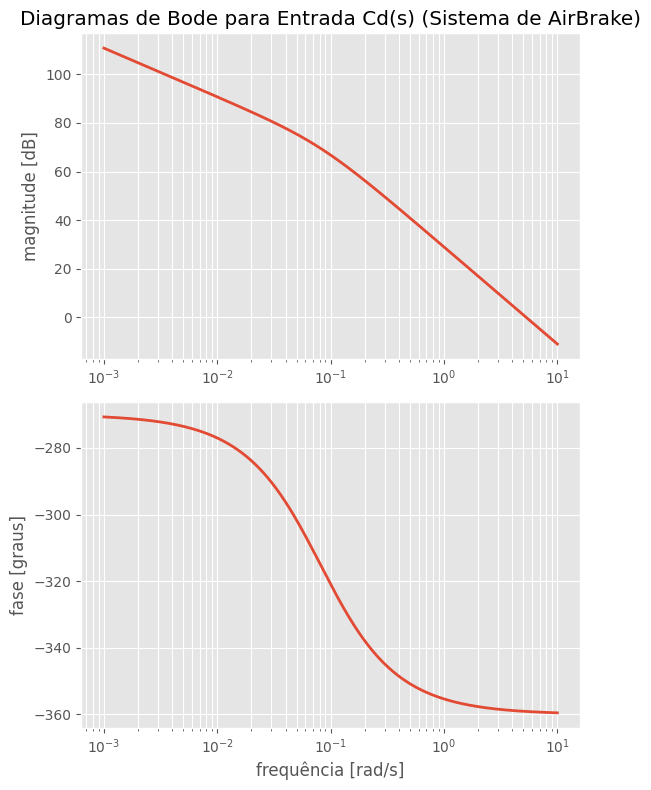

In [83]:
plt.figure(figsize=(6, 8))

mag, phase, omega = ct.bode(T1, omega_limits=(0.001, 10), plot=False)

plt.subplot(2, 1, 1)
plt.title("Diagramas de Bode para Entrada Cd(s) (Sistema de AirBrake)")
plt.semilogx(omega, 20 * np.log10(mag), linewidth=2)
plt.ylabel("magnitude [dB]")
plt.grid(True, which="both")

plt.subplot(2, 1, 2)
plt.semilogx(omega, np.rad2deg(phase), linewidth=2)
plt.ylabel("fase [graus]")
plt.xlabel("frequência [rad/s]")
plt.grid(True, which="both")

plt.tight_layout()
plt.show()

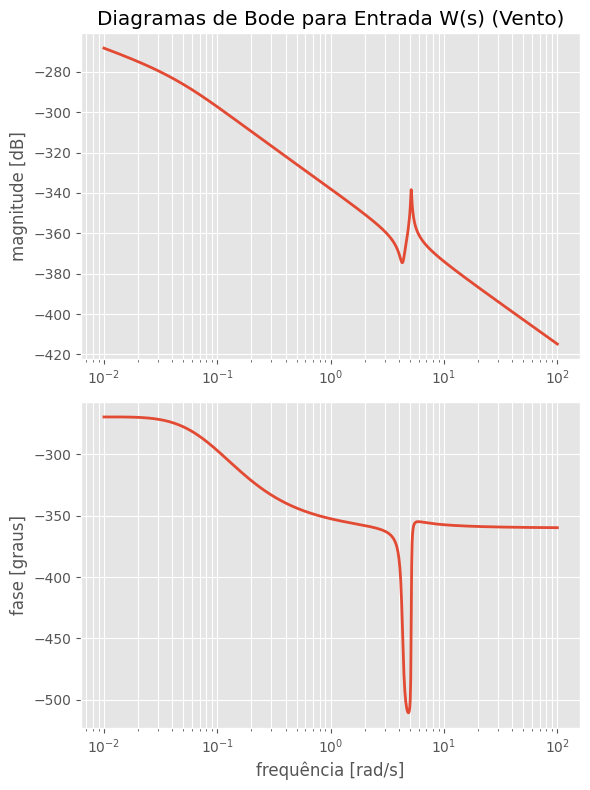

In [84]:
plt.figure(figsize=(6, 8))

mag, phase, omega = ct.bode(T2, omega_limits=(0.01, 100), plot=False)

plt.subplot(2, 1, 1)
plt.title("Diagramas de Bode para Entrada W(s) (Vento)")
plt.semilogx(omega, 20 * np.log10(mag), linewidth=2)
plt.ylabel("magnitude [dB]")
plt.grid(True, which="both")

plt.subplot(2, 1, 2)
plt.semilogx(omega, np.rad2deg(phase), linewidth=2)
plt.ylabel("fase [graus]")
plt.xlabel("frequência [rad/s]")
plt.grid(True, which="both")

plt.tight_layout()
plt.show()

Os diagramas apresentam todos comportamento próximo de primeira ordem ao redor de baixas frequências, representando ganho alto para entradas constantes, assim como esperado para o comportamento de imputs do tipo força e saídas posicionais.
Em altas frequências $G2$ apresentou um comportamento de segunda ordem, esperado pelo fato de, próximo a frequência natural, a velocidade do vento promove grandes oscilações do foguete ao redor de seu eixo, devido a um grande acoplamento de equacionamentos.

###Análise No Tempo Para Entradas Padrão

Resposta no Tempo para entradas Padrão para $G_1(s)$

In [85]:
stepG1 = ct.step_response(T1, np.linspace(0, 5, 500))
impulseG1 = ct.impulse_response(T1, np.linspace(0, 5, 500))
time_vector = np.linspace(0, 5, 500)
ramp_input = time_vector
rampG1 = ct.forced_response(T1, time_vector, ramp_input)

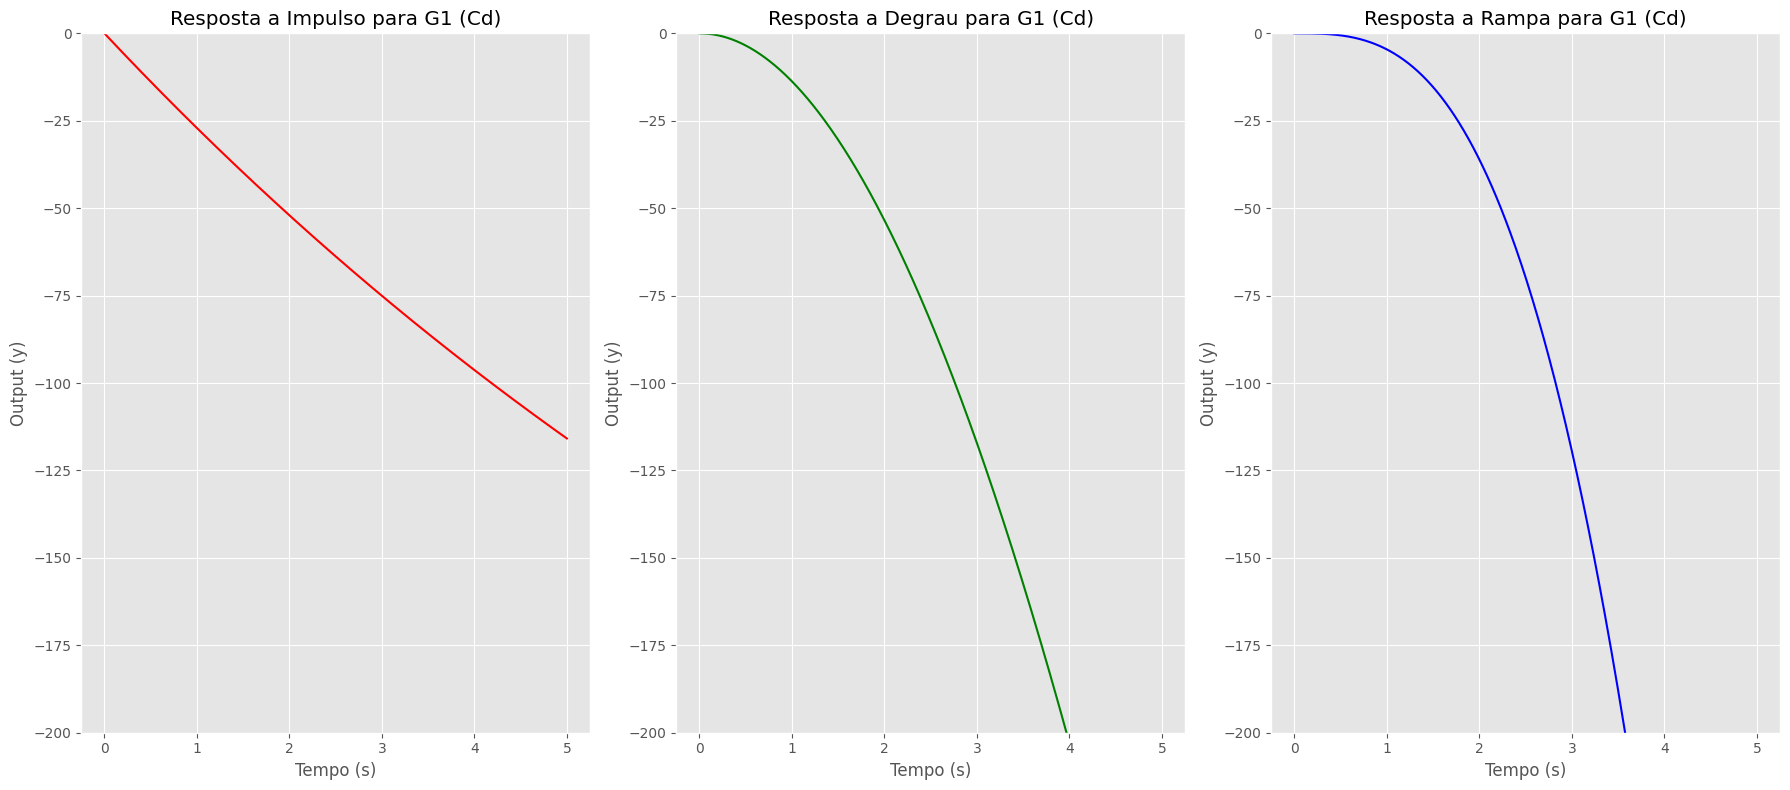

In [86]:
plt.figure(figsize=(18, 8))

# Calculate global min and max for y-axis across all responses
all_outputs = np.concatenate([rampG1.outputs, impulseG1.outputs, stepG1.outputs])
y_min = -200
y_max = np.max(all_outputs)

plt.subplot(1, 3, 1)
plt.plot(impulseG1.time, impulseG1.outputs, color='red')
plt.title("Resposta a Impulso para G1 (Cd)")
plt.xlabel("Tempo (s)")
plt.ylabel("Output (y)")
plt.grid(True)
plt.ylim(y_min, y_max) # Apply global y-limits

plt.subplot(1, 3, 2)
plt.plot(stepG1.time, stepG1.outputs, color='green')
plt.title("Resposta a Degrau para G1 (Cd)")
plt.xlabel("Tempo (s)")
plt.ylabel("Output (y)")
plt.grid(True)
plt.ylim(y_min, y_max) # Apply global y-limits

plt.subplot(1, 3, 3)
plt.plot(rampG1.time, rampG1.outputs, color='blue')
plt.title("Resposta a Rampa para G1 (Cd)")
plt.xlabel("Tempo (s)")
plt.ylabel("Output (y)")
plt.grid(True)
plt.ylim(y_min, y_max) # Apply global y-limits

plt.tight_layout()
plt.show()

Resposta no Tempo para entradas Padrão em $G_2(s)$

In [87]:
stepG2 = ct.step_response(T2, np.linspace(0, 5, 500))
impulseG2 = ct.impulse_response(T2, np.linspace(0, 5, 500))
time_vector = np.linspace(0, 5, 500)
ramp_input = time_vector
rampG2 = ct.forced_response(T2, time_vector, ramp_input)

/usr/local/lib/python3.12/dist-packages/scipy/signal/_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


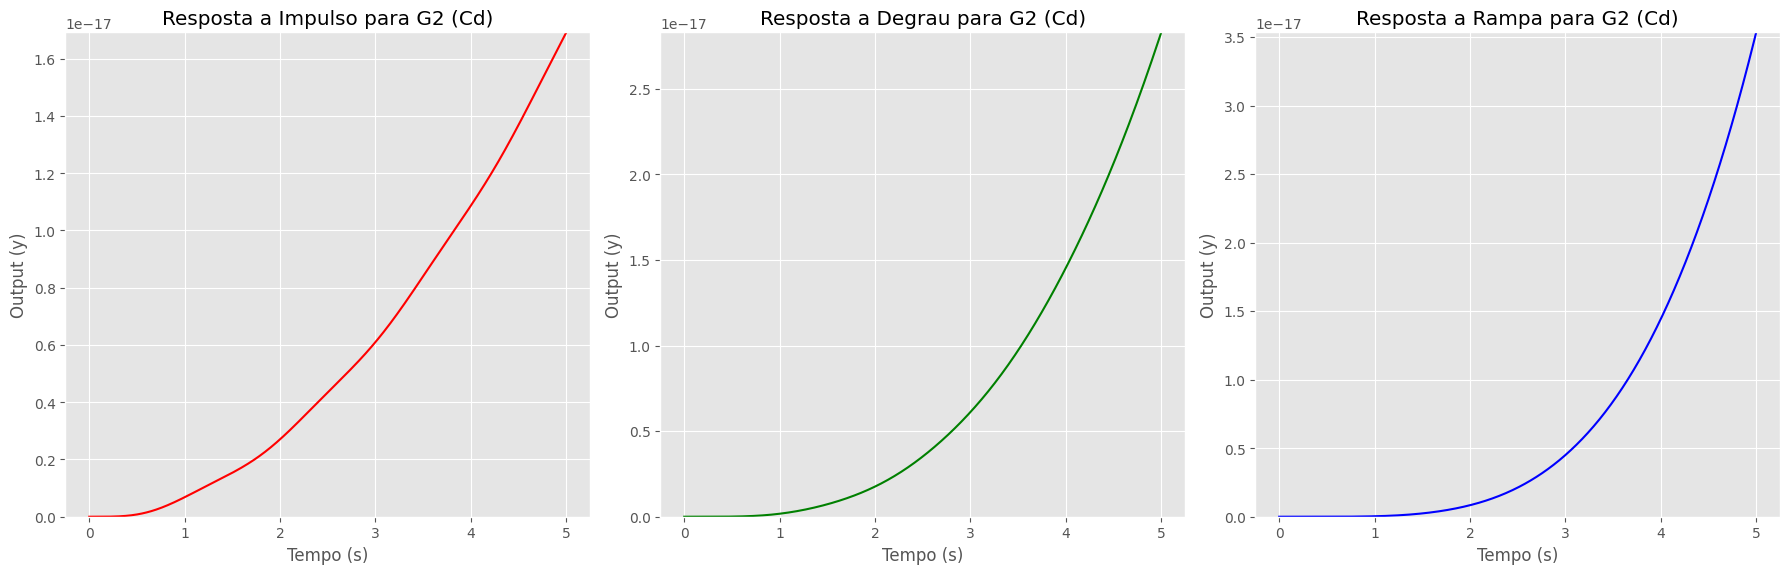

In [88]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(impulseG2.time, impulseG2.outputs, color='red')
plt.title("Resposta a Impulso para G2 (Cd)")
plt.xlabel("Tempo (s)")
plt.ylabel("Output (y)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.subplot(1, 3, 2)
plt.plot(stepG2.time, stepG2.outputs, color='green')
plt.title("Resposta a Degrau para G2 (Cd)")
plt.xlabel("Tempo (s)")
plt.ylabel("Output (y)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.subplot(1, 3, 3)
plt.plot(rampG2.time, rampG2.outputs, color='blue')
plt.title("Resposta a Rampa para G2 (Cd)")
plt.xlabel("Tempo (s)")
plt.ylabel("Output (y)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.tight_layout()
plt.show()

###Simulações Numéricas
Simulações com condição inicial de $\dot y = 240 m/s$ e demais componentes zeradas, de forma a avaliar o efeito do vento sobre o foguete nos dois modelos possíveis, permitindo uma validação do modelo linearizado

Simulação Não Linearizada

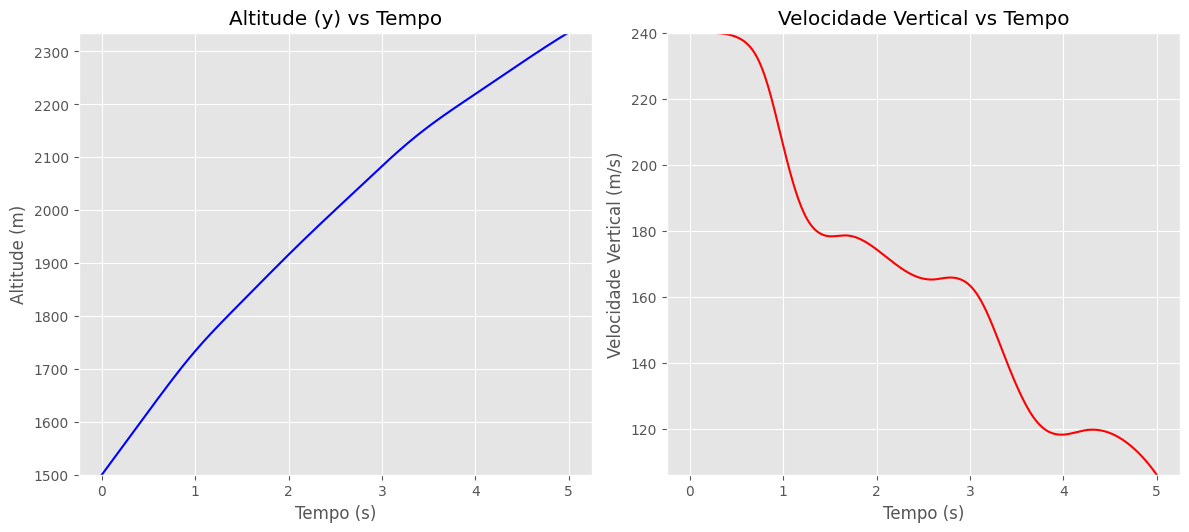

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

m = 27.0
T = 558.26
Jg = 12.622
A_f = 0.021
A_m = 0.021
g = 9.81
rho = 1.225
D_Cp = 0.381
Cl = 1.5
Cd = 0.35
w = 6.0

# Definição das Equações Diferenciais
def dxdt(t, x):
    x, y, theta, vx, vy, omega = x

    if abs(vy) < 1e-3:
        vy = 1e-3

    vx_rel = vx - w
    vy_rel = vy
    v_sq = vx_rel**2 + vy_rel**2

    phi = np.pi/2 - np.arctan2(vx_rel, vy_rel)
    alpha = phi - theta

    D = 0.5 * rho * A_f * v_sq * Cd
    L = 0.5 * rho * A_m * v_sq * Cl * abs(alpha)

    fx = -L * np.cos(phi) - D * np.cos(phi) + T * np.cos(theta)
    ax = fx / m

    fy = L * np.sin(phi+np.pi) - D * np.sin(phi) + T * np.sin(theta) - m * g
    ay = fy / m

    torque = L * D_Cp * np.cos(alpha+np.pi) - D * D_Cp * np.sin(alpha)
    acc_theta = torque / Jg

    return [vx, vy, omega, ax, ay, acc_theta]

# Condições Iniciais
y0 = [0, 1500, np.pi/2, 0, 240, 0]

# Tempo de simulação (0 a 20 segundos)
t_span = (0, 5)
t_eval = np.linspace(0, 5, 500)

sol = solve_ivp(dxdt, t_span, y0, t_eval=t_eval, method='RK45')

# Visualização dos Resultados
plt.figure(figsize=(12, 10))

# Altitude
plt.subplot(2, 2, 1)
plt.plot(sol.t, sol.y[1], color='blue')
plt.title("Altitude (y) vs Tempo")
plt.xlabel("Tempo (s)")
plt.ylabel("Altitude (m)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.subplot(2, 2, 2)
plt.plot(sol.t, sol.y[4], color='red')
plt.title("Velocidade Vertical vs Tempo")
plt.xlabel("Tempo (s)")
plt.ylabel("Velocidade Vertical (m/s)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.tight_layout()
plt.show()

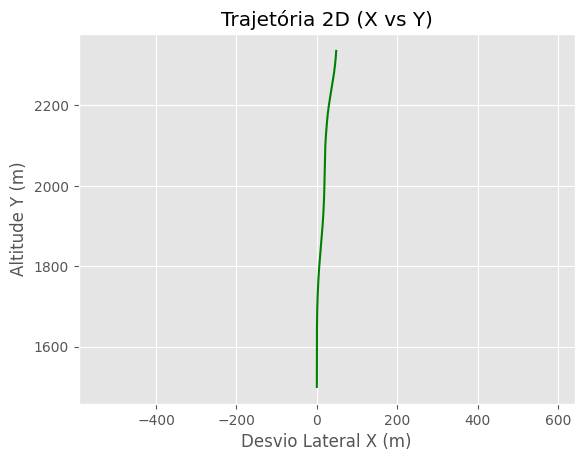

In [90]:
plt.plot(sol.y[0], sol.y[1], color='green')
plt.title("Trajetória 2D (X vs Y)")
plt.xlabel("Desvio Lateral X (m)")
plt.ylabel("Altitude Y (m)")
plt.axis('equal')
plt.grid(True)

Simulação do Sistema Linear

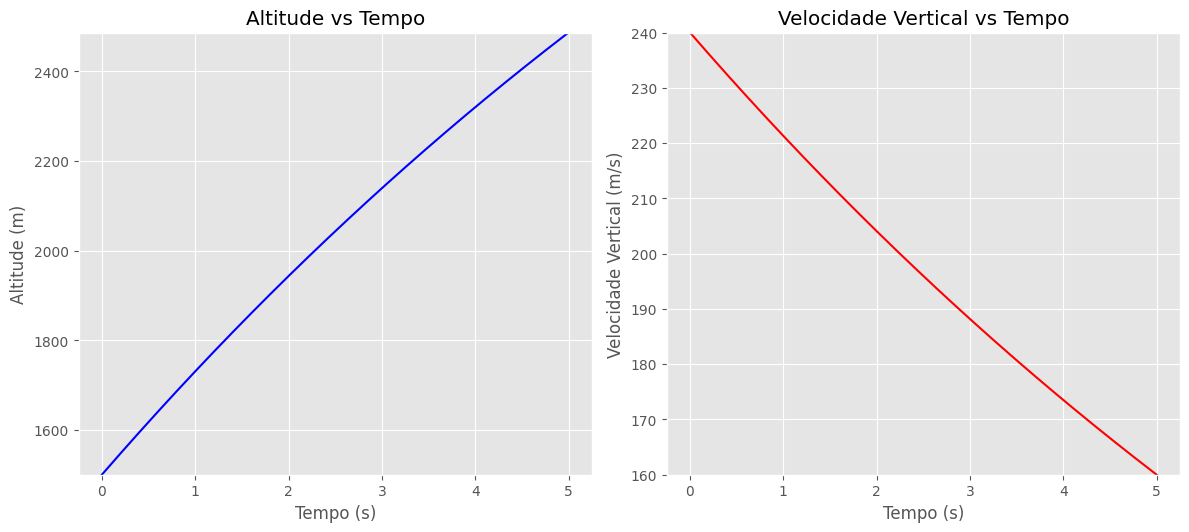

In [91]:
A_np = np.array(A).astype(np.float64)
B_np = np.array(B).astype(np.float64)
E_np = np.array(E).astype(np.float64)
deltaCd = 0
deltaw = 0
deltaT = 0
def lindxdt(t, x):
    BdCd = (B_np * deltaCd).flatten()
    Edw = (E_np * deltaw).flatten()
    dxdt = A_np@x + BdCd + Edw
    return dxdt.flatten()


y0 = [1500, 0, 0, 240, 0]

# Tempo de simulação (0 a 20 segundos)
t_span = (0, 5)
t_eval = np.linspace(0, 5, 500) # Pontos para o gráfico

# 4. Execução (Integração Numérica)
sol_lin = solve_ivp(lindxdt, t_span, y0, t_eval=t_eval, method='RK45')

# 5. Visualização dos Resultados (Atualizando títulos para refletir variáveis incrementais)
plt.figure(figsize=(12, 10))

# Desvio Lateral Y Incremental
plt.subplot(2, 2, 1)
plt.plot(sol_lin.t, sol_lin.y[0], color='blue')
plt.title("Altitude vs Tempo")
plt.xlabel("Tempo (s)")
plt.ylabel("Altitude (m)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.subplot(2, 2, 2)
plt.plot(sol_lin.t, sol_lin.y[3], color='red')
plt.title("Velocidade Vertical vs Tempo")
plt.xlabel("Tempo (s)")
plt.ylabel("Velocidade Vertical (m/s)")
plt.grid(True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.tight_layout()
plt.show()

(1500.0, 2486.4733835066518)

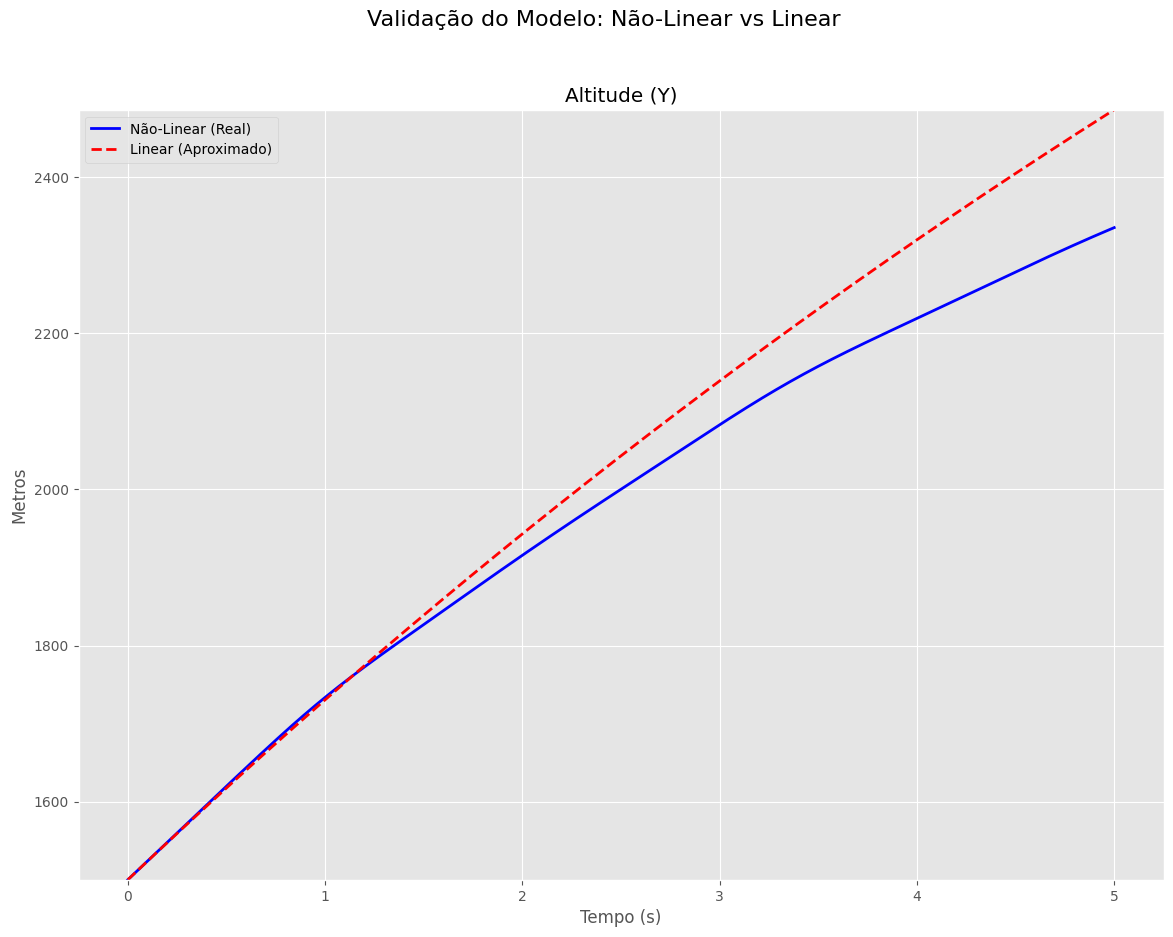

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
fig.suptitle("Validação do Modelo: Não-Linear vs Linear", fontsize=16)

# Non-linear altitude
altitude_nonlinear = sol.y[1]

# Linear altitude (add initial equilibrium altitude to incremental change)
altitude_linear_absolute = sol_lin.y[0]

ax.plot(sol.t, altitude_nonlinear, 'b-', label='Não-Linear (Real)', linewidth=2)
ax.plot(sol_lin.t, altitude_linear_absolute, 'r--', label='Linear (Aproximado)', linewidth=2)

ax.set_title("Altitude (Y)")
ax.set_ylabel("Metros")
ax.set_xlabel("Tempo (s)")
ax.legend()
ax.grid(True)

# Calculate common y-limits for both plots
min_y = min(np.min(altitude_nonlinear), np.min(altitude_linear_absolute))
max_y = max(np.max(altitude_nonlinear), np.max(altitude_linear_absolute))
ax.set_ylim(min_y, max_y)

A proximidade dos valores para t até ~2s demonstra que o sistema linearizado aproxima devidamente a dinâmica de voo, sendo o grande desvio criado após isso devido a instabilidade intrinseca ao sistema, que demonstra a incapacidade do modelo linear prever completamente o comportamento do foguete.

Além disso, o menor valor final de altitude deve-se pelo fato do modelo dinâmico capturar a força de arrasto como proporcional a $v^2$, enquanto o modelo linear captura como coeficiente constante na matriz $A$.